In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, HuberRegressor
import sklearn.metrics as metrics
# import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def load_files(f):
    """
    converts from dictionary of CSVs to dictionary of dataframes
    """
    dfs = {}
    for k,v in f.items():
        dfs[k] = pd.read_csv(v)
    return dfs

def calculate_price_usd(row):
    """
    calculates price in USD for each row using appropriate FX
    """
    if row['Country'] == 'JP':
        return row['Price']/row['JP/US']
    elif row['Country'] == 'UK':
        return row['Price']*row['US/UK']
    else:
        return row['Price']

In [14]:
files = {
    #PLEASE MODIFY THE BELOW STRINGS WITH LOCATION OF FILES
    'S':'stock.csv',
    'F':'fx.csv',
    'C':'classification.csv',
}
data = load_files(files)

In [4]:
#correcting CSV date formats 
data['F']['Date'] = pd.to_datetime(data['F']['Date'],format='%Y-%m-%d') 
data['S']['Date'] = pd.to_datetime(data['S']['Date'],format='%d/%m/%Y')

#joining all dataframes to calculate traded value USD
df = pd.merge(data['S'],data['C'],how='inner',on='ID')
df = pd.merge(df,data['F'],how='inner',on='Date')
df['Price_USD'] = df.apply(lambda row: calculate_price_usd(row), axis=1)
df['traded_value'] = df['Price_USD']*df['Volume']

df = df.sort_values(['ID','Date'])
stock = df.groupby('ID')

#adding 1 day forward traded value to be used as dependent variable in analysis later
df = pd.DataFrame()
for id,id_df in stock:
    id_df['traded_value_1D'] = id_df['traded_value'].shift(-1)
    #adding 1 day forward volatility forecast since it is available BEFORE start of trading
    id_df['Volatility_1D'] = id_df['Volatility'].shift(-1)
    id_df['Price_chg'] = id_df['Price_USD'].pct_change()
    df = pd.concat([df,id_df])  

df.dropna(inplace=True)

<AxesSubplot:>

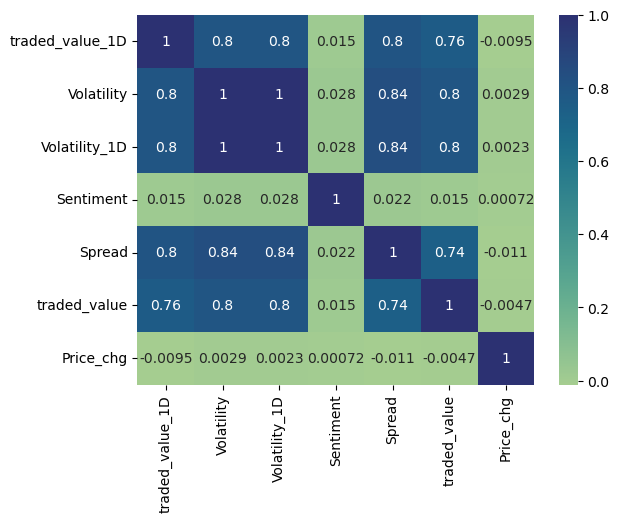

In [5]:
#creating correlation matrix to decide which independent variables to pick for X
cor_matrix = df[['traded_value_1D','Volatility','Volatility_1D','Sentiment', 'Spread','traded_value','Price_chg']].corr()
# plot the heatmap
sns.heatmap(cor_matrix, 
        xticklabels=cor_matrix.columns,
        yticklabels=cor_matrix.columns,
           annot=True,
           cmap="crest")

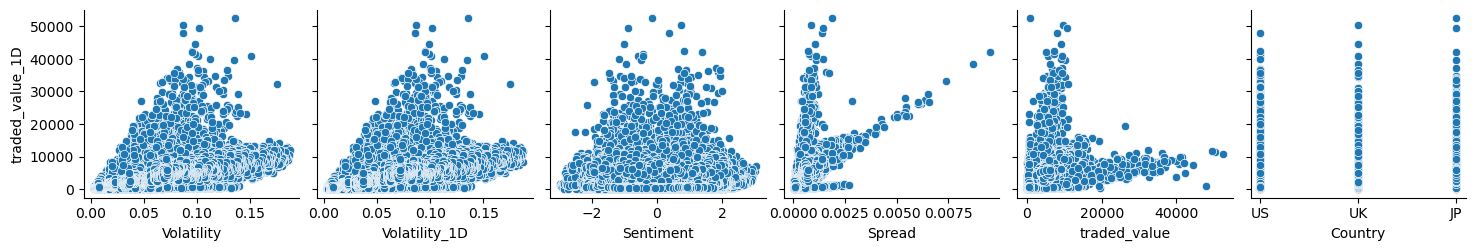

In [6]:
#to further analyze relationship between dependent variable Y and possible independent variables X
sns.pairplot(data=df,y_vars=['traded_value_1D'],x_vars=['Volatility','Volatility_1D','Sentiment', 'Spread','traded_value','Country'])
plt.show()

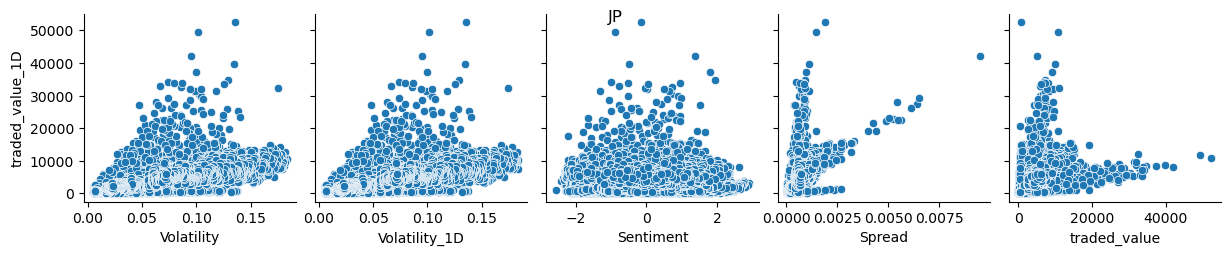

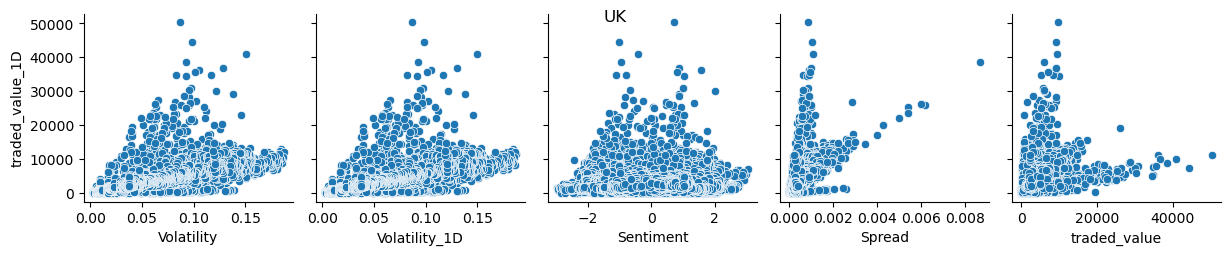

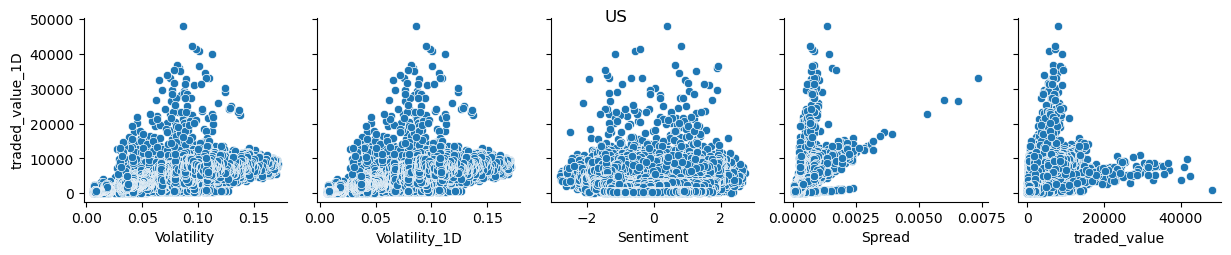

In [7]:
#to make sure that different countries dont require different models or require dummy binary variables for each country
country = df.groupby('Country')
for c,c_df in country:
    g = sns.pairplot(data=c_df,y_vars=['traded_value_1D'],x_vars=['Volatility','Volatility_1D','Sentiment', 'Spread','traded_value'])
    g.fig.suptitle(c)
    plt.show()

Choosing Volatility, Spread and Traded Value for independent variables since high correlation with 1D forward Traded Value

In [8]:
#splitting data into training and testing sets - 80/20
x = df[['traded_value','Volatility','Spread']]
y = df['traded_value_1D']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

Evaluating different regression models : Linear, Huber, Lasso, ElasticNet

In [9]:
m_linear = LinearRegression()
output = m_linear.fit(x_train,y_train).predict(x_test)
print("R2: %.2f" % metrics.r2_score(y_test,output))
print("MAE: %.0f" % metrics.mean_absolute_error(y_test,output))
print("RMSE: %.0f" % np.sqrt(metrics.mean_squared_error(y_test,output)))

R2: 0.71
MAE: 758
RMSE: 1362


In [10]:
m_huber = HuberRegressor()
output = m_huber.fit(x_train,y_train).predict(x_test)
print("R2: %.2f" % metrics.r2_score(y_test,output))
print("MAE: %.0f" % metrics.mean_absolute_error(y_test,output))
print("RMSE: %.0f" % np.sqrt(metrics.mean_squared_error(y_test,output)))

R2: 0.54
MAE: 907
RMSE: 1731


In [11]:
m_lasso = Lasso(alpha=0.1)
output = m_lasso.fit(x_train,y_train).predict(x_test)
print("R2: %.2f" % metrics.r2_score(y_test,output))
print("MAE: %.0f" % metrics.mean_absolute_error(y_test,output))
print("RMSE: %.0f" % np.sqrt(metrics.mean_squared_error(y_test,output)))

R2: 0.67
MAE: 818
RMSE: 1464


In [12]:
m_elasticnet = ElasticNet(alpha=0.1,l1_ratio=0.7)
output = m_elasticnet.fit(x_train,y_train).predict(x_test)
print("R2: %.2f" % metrics.r2_score(y_test,output))
print("MAE: %.0f" % metrics.mean_absolute_error(y_test,output))
print("RMSE: %.0f" % np.sqrt(metrics.mean_squared_error(y_test,output)))

R2: 0.57
MAE: 974
RMSE: 1672


Choosing Linear Regression

In [13]:
pd.DataFrame({"Feature":x_train.columns.tolist(),"Coefficients ":m_linear.coef_})

,Feature,Coefficients
0,traded_value,2.644928e-01
1,Volatility,2.102325e+04
2,Spread,3.325692e+06
